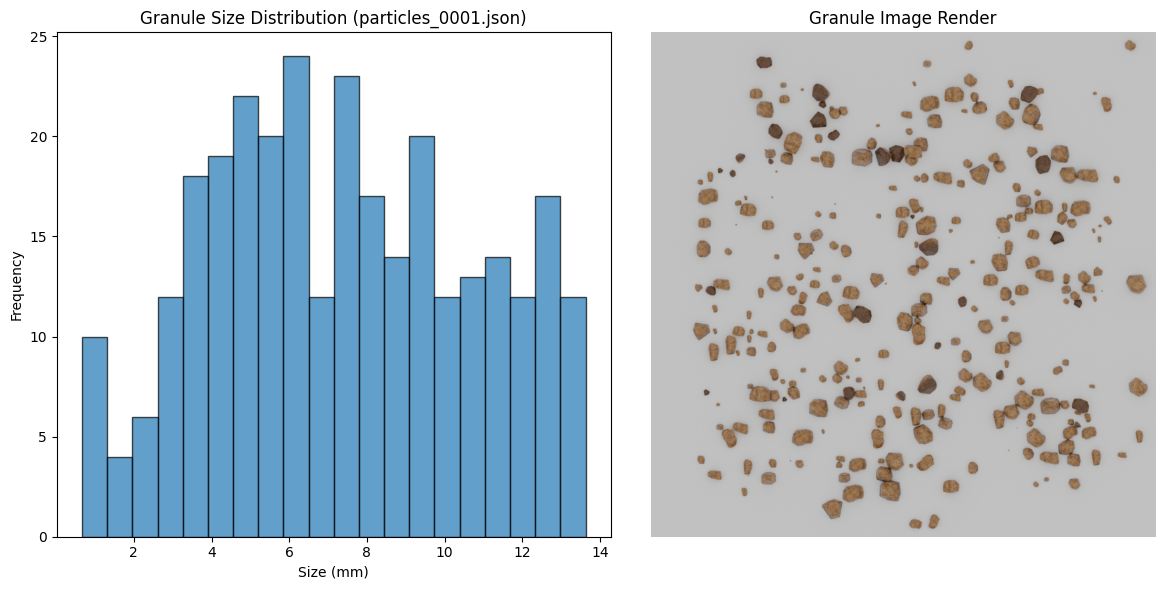

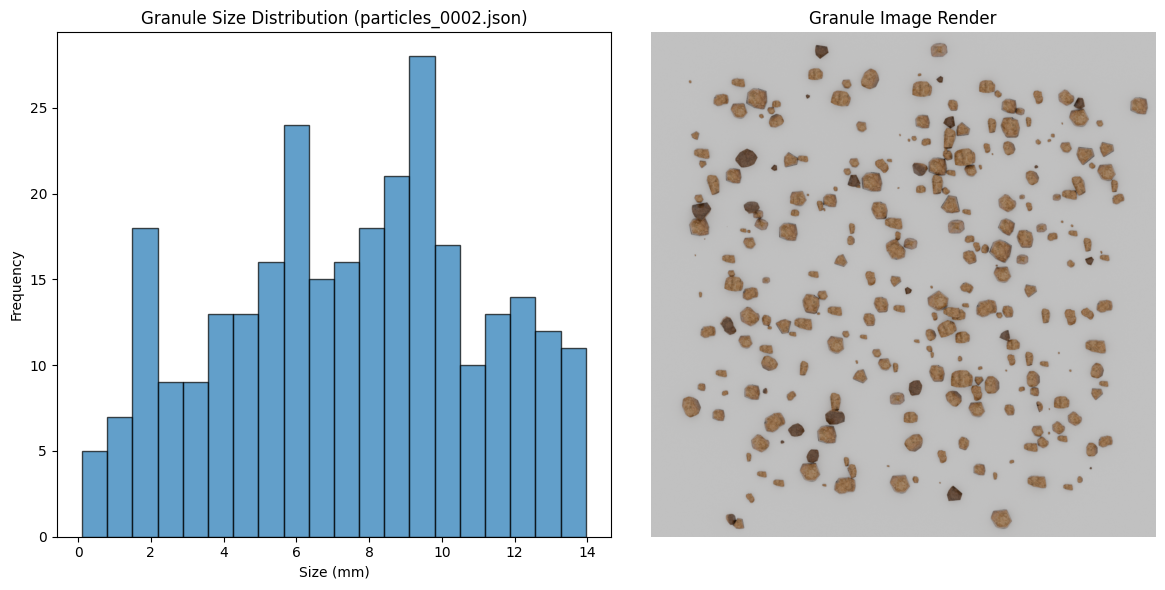

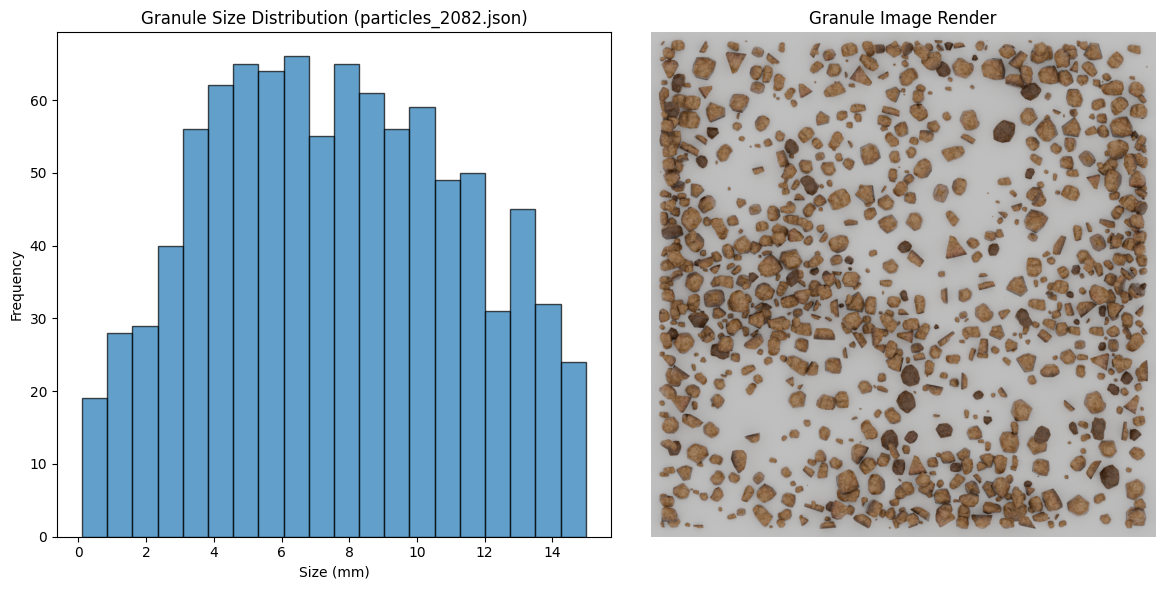

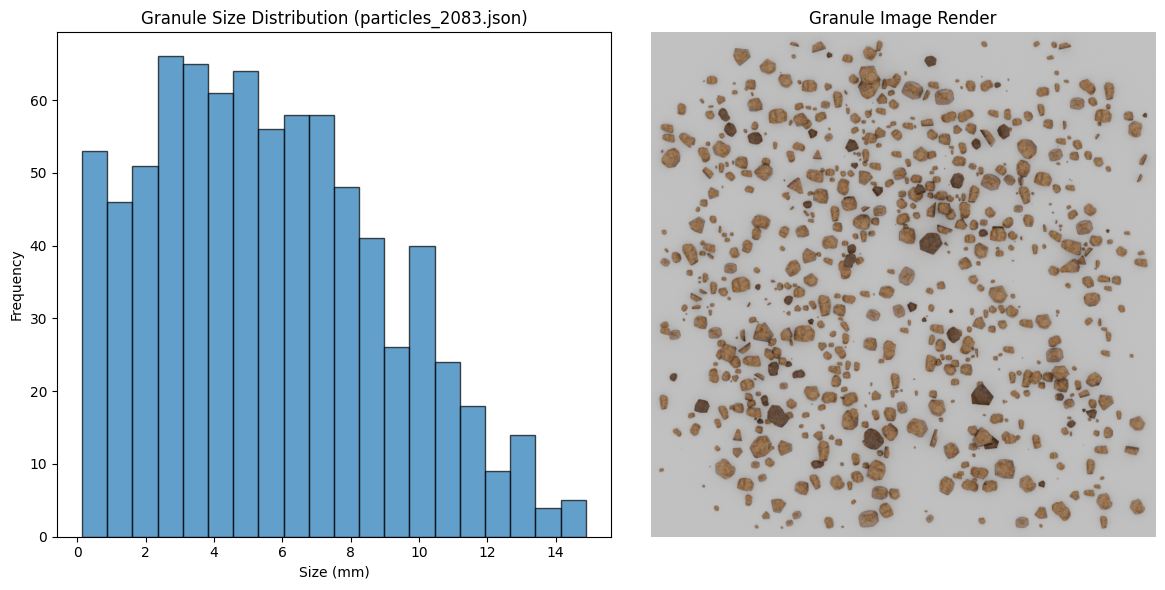

In [3]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

# Paths
json_folder = "dataset/particles"
image_folder = "dataset/renders"

# Get a list of all JSON files in the particles folder
json_files = sorted(glob.glob(os.path.join(json_folder, "*.json")))

# Ensure there are enough files to sample
if len(json_files) < 4:
    print("Not enough JSON files to sample from.")
    exit()

# Select 2 samples from the beginning and 2 from the end
selected_json_files = json_files[:2] + json_files[-2:]

for json_file in selected_json_files:
    # Extract the number from the JSON file name (assumes format "particles_XXXX.json")
    base_name = os.path.basename(json_file)  # e.g., particles_0001.json
    try:
        number = base_name.split('_')[1].split('.')[0]  # "0001"
    except IndexError:
        print(f"Unexpected file name format: {base_name}")
        continue

    # Build the corresponding image file name (assumes format "render_XXXX.png")
    image_filename = f"render_{number}.png"
    image_path = os.path.join(image_folder, image_filename)

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Image file not found for {base_name}: {image_path}")
        continue

    # Load JSON data
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            sizes = [particle['size'] for particle in data.get('particles', [])]
    except Exception as e:
        print(f"Error processing {json_file}: {e}")
        continue

    # Load Image
    img = Image.open(image_path)

    # Visualization
    plt.figure(figsize=(12, 6))
    
    # Histogram of sizes
    plt.subplot(1, 2, 1)
    plt.hist(sizes, bins=20, edgecolor='k', alpha=0.7)
    plt.title(f"Granule Size Distribution ({base_name})")
    plt.xlabel("Size (mm)")
    plt.ylabel("Frequency")
    
    # Rendered Image
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Granule Image Render")
    
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np

d50 = np.percentile(sizes, 50)  # Median size
d10 = np.percentile(sizes, 10)
d90 = np.percentile(sizes, 90)

print(f"d50: {d50} mm, d10: {d10} mm, d90: {d90} mm")


d50: 5.288624904662563 mm, d10: 1.3453159862866932 mm, d90: 10.36168149766391 mm


In [6]:
import os
import json
import pandas as pd
import numpy as np

# Root folder containing the dataset
root_folder = "dataset"
output_csv = "granules_dataset.csv"

# Helper function to calculate size distribution percentiles
def calculate_percentiles(size_list):
    return {
        "d10": np.percentile(size_list, 10),
        "d50": np.percentile(size_list, 50),
        "d90": np.percentile(size_list, 90)
    }

# Define the particles and renders folders
particles_folder = os.path.join(root_folder, "particles")
renders_folder = os.path.join(root_folder, "renders")

# Check if both folders exist
if not os.path.exists(particles_folder) or not os.path.exists(renders_folder):
    print(f"Missing 'particles' or 'renders' folder in {root_folder}.")
    exit()

dataset = []
for json_file in os.listdir(particles_folder):
    if json_file.endswith(".json"):
        # Expecting format "particles_XXXX.json"
        base_name = os.path.basename(json_file)
        try:
            number = base_name.split('_')[1].split('.')[0]
        except IndexError:
            print(f"Unexpected file name format: {base_name}")
            continue

        # Construct corresponding image file name: "render_XXXX.png"
        image_file = f"render_{number}.png"
        image_path = os.path.join(renders_folder, image_file)

        # Skip if the image file does not exist
        if not os.path.exists(image_path):
            print(f"Image not found for {json_file}, skipping...")
            continue

        json_path = os.path.join(particles_folder, json_file)
        try:
            with open(json_path, "r") as f:
                data = json.load(f)
                sizes = [particle["size"] for particle in data.get("particles", [])]
                percentiles = calculate_percentiles(sizes)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON file {json_path}: {e}, skipping...")
            continue

        # Add the record to the dataset
        dataset.append({
            "image_path": image_path,
            **percentiles
        })

# Save the dataset to a CSV file
df = pd.DataFrame(dataset)
df.to_csv(output_csv, index=False)

print(f"Dataset created and saved to {output_csv}")


Dataset created and saved to granules_dataset.csv
